- Labels in this dataset:

    - Hardhat
    - Safety Vest
    - Gloves
    - Person

- Number of classes: 4
- Label Annotation: YOLO format (.txt):
              `[class_id, center_x, center_y, width, height]`



Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

In [2]:
class CFG:
    CLASSES = ['Hardhat','Safety Vest','Gloves','Person']
    # CLASSES = ['Hardhat',
    #            'NO-Hardhat',
    #            'Safety Vest',
    #            'NO-Safety Vest',
    #            'Gloves',
    #            'NO-Gloves',
    #            'Person']
    IMAGES_DIR = '../data/dataset_v4/images'
    LABELS_DIR = '../data/dataset_v4/labels'

    DATA_YAML = '../data/data-ppe_v2.yaml'

# Dataset

- Check some images
- Image utils

## Visualize many images

In [3]:
# ...existing code...
def plot_random_images_from_folder(folder_path, image_size=(224, 224), id=1, labels_dir=CFG.LABELS_DIR, classes=CFG.CLASSES):
    """
    Show up to 12 random images with their YOLO bounding boxes.
    YOLO label format per line: class_id cx cy w h  (all normalized 0-1)
    """
    exts = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.webp')
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(exts)]
    if not image_files:
        print("No images found.")
        return
    if id == -1:
        image_files = random.sample(image_files, min(len(image_files), 16))
    else:
        image_files = image_files[id*16:(id+1)*16]
    for num, f in enumerate(image_files):
        print(num + 1, f)
    num_cols = 4
    num_rows = int(np.ceil(len(image_files) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
    if num_rows == 1:
        axes = np.array([axes])  # ensure 2D indexable

    # Color palette for classes
    palette = plt.cm.get_cmap('tab10', len(classes))

    for idx, file_name in enumerate(image_files):
        ax = axes[idx // num_cols, idx % num_cols]
        img_path = os.path.join(folder_path, file_name)
        img = Image.open(img_path).convert("RGB")
        orig_w, orig_h = img.size

        # Load labels
        label_path = os.path.join(labels_dir, os.path.splitext(file_name)[0] + '.txt')
        boxes = []
        if os.path.isfile(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue
                    cls_id = int(parts[0])
                    cx, cy, bw, bh = map(float, parts[1:5])
                    # Convert normalized to original pixel coords
                    box_w = bw * orig_w
                    box_h = bh * orig_h
                    center_x = cx * orig_w
                    center_y = cy * orig_h
                    x1 = center_x - box_w / 2
                    y1 = center_y - box_h / 2
                    x2 = center_x + box_w / 2
                    y2 = center_y + box_h / 2
                    boxes.append((cls_id, x1, y1, x2, y2))

        # Resize image for display
        disp_w, disp_h = image_size
        img_resized = img.resize((disp_w, disp_h))
        ax.imshow(img_resized)
        ax.axis('off')
        ax.set_title(file_name, fontsize=8)

        # Scale factor
        scale_x = disp_w / orig_w
        scale_y = disp_h / orig_h

        # Draw boxes
        for (cls_id, x1, y1, x2, y2) in boxes:
            sx1 = x1 * scale_x
            sy1 = y1 * scale_y
            sw = (x2 - x1) * scale_x
            sh = (y2 - y1) * scale_y
            color = palette(cls_id % len(classes)) if classes else (1, 0, 0, 1)
            rect = Rectangle((sx1, sy1), sw, sh,
                             edgecolor=color,
                             facecolor='none',
                             linewidth=1.5)
            ax.add_patch(rect)
            label_txt = f"{cls_id}"
            if 0 <= cls_id < len(classes):
                label_txt += f":{classes[cls_id]}"
            ax.text(sx1, sy1 - 2,
                    label_txt,
                    fontsize=7,
                    color='white',
                    bbox=dict(boxstyle='round,pad=0.2',
                              fc=color,
                              ec='none',
                              alpha=0.8))

    # Hide unused subplots
    total_axes = num_rows * num_cols
    for k in range(len(image_files), total_axes):
        axes[k // num_cols, k % num_cols].axis('off')

    plt.tight_layout()
    plt.show()
# ...existing code...

1 youtube-693_jpg.rf.eab06a82d0b7b1042dba2a3ef060effc.jpg
2 00060_jpg.rf.f6f7022651feeffb4a7c58adcbc34f6f.jpg
3 ppe_0559_jpg.rf.1d9b5f11f9a3f6b68227b6e9961e2c2c.jpg
4 rt_jpg.rf.9a21426085fbce79e40f1146104d3911.jpg
5 ppe_0106_jpg.rf.2c39839337d220876f95b86dbd4d59b4.jpg
6 istockphoto-1355322612-612x612_jpg.rf.3e0fdb80e349bbae83197b06a48f0348.jpg
7 istockphoto-1391198777-612x612_jpg.rf.d57d78a117c5753b23d3cac1d0ee38a6.jpg
8 Demonstration-of-Donning-Putting-On-Personal-Protective-Equipment-PPE-011_jpg.rf.d52a7ed43feb59542ef597794ef4677e.jpg
9 frame_000140_jpg.rf.4b070b1ad55d52e89613760953d9df96.jpg
10 phifs1301_jpg.rf.04f79dc4254c554e36373ba77ad35204.jpg
11 ppe_0568_jpg.rf.47100a2bd5f1661d93ffda066339e86a.jpg
12 youtube-242_jpg.rf.1aeeb22a1de44de3171f8c1c9822443b.jpg
13 youtube-697_jpg.rf.d0c6113833ac3697379cc4ae259e4304.jpg
14 ppe_1051_jpg.rf.348d186cc40bc4b288f685c22506ecdf.jpg
15 ppe_0069_jpg.rf.bd6e9a7190791603e0bc17f671a29e03.jpg
16 ppe_0471_jpg.rf.817919a6cc57062c2e9d4e4e730a52ac.jpg

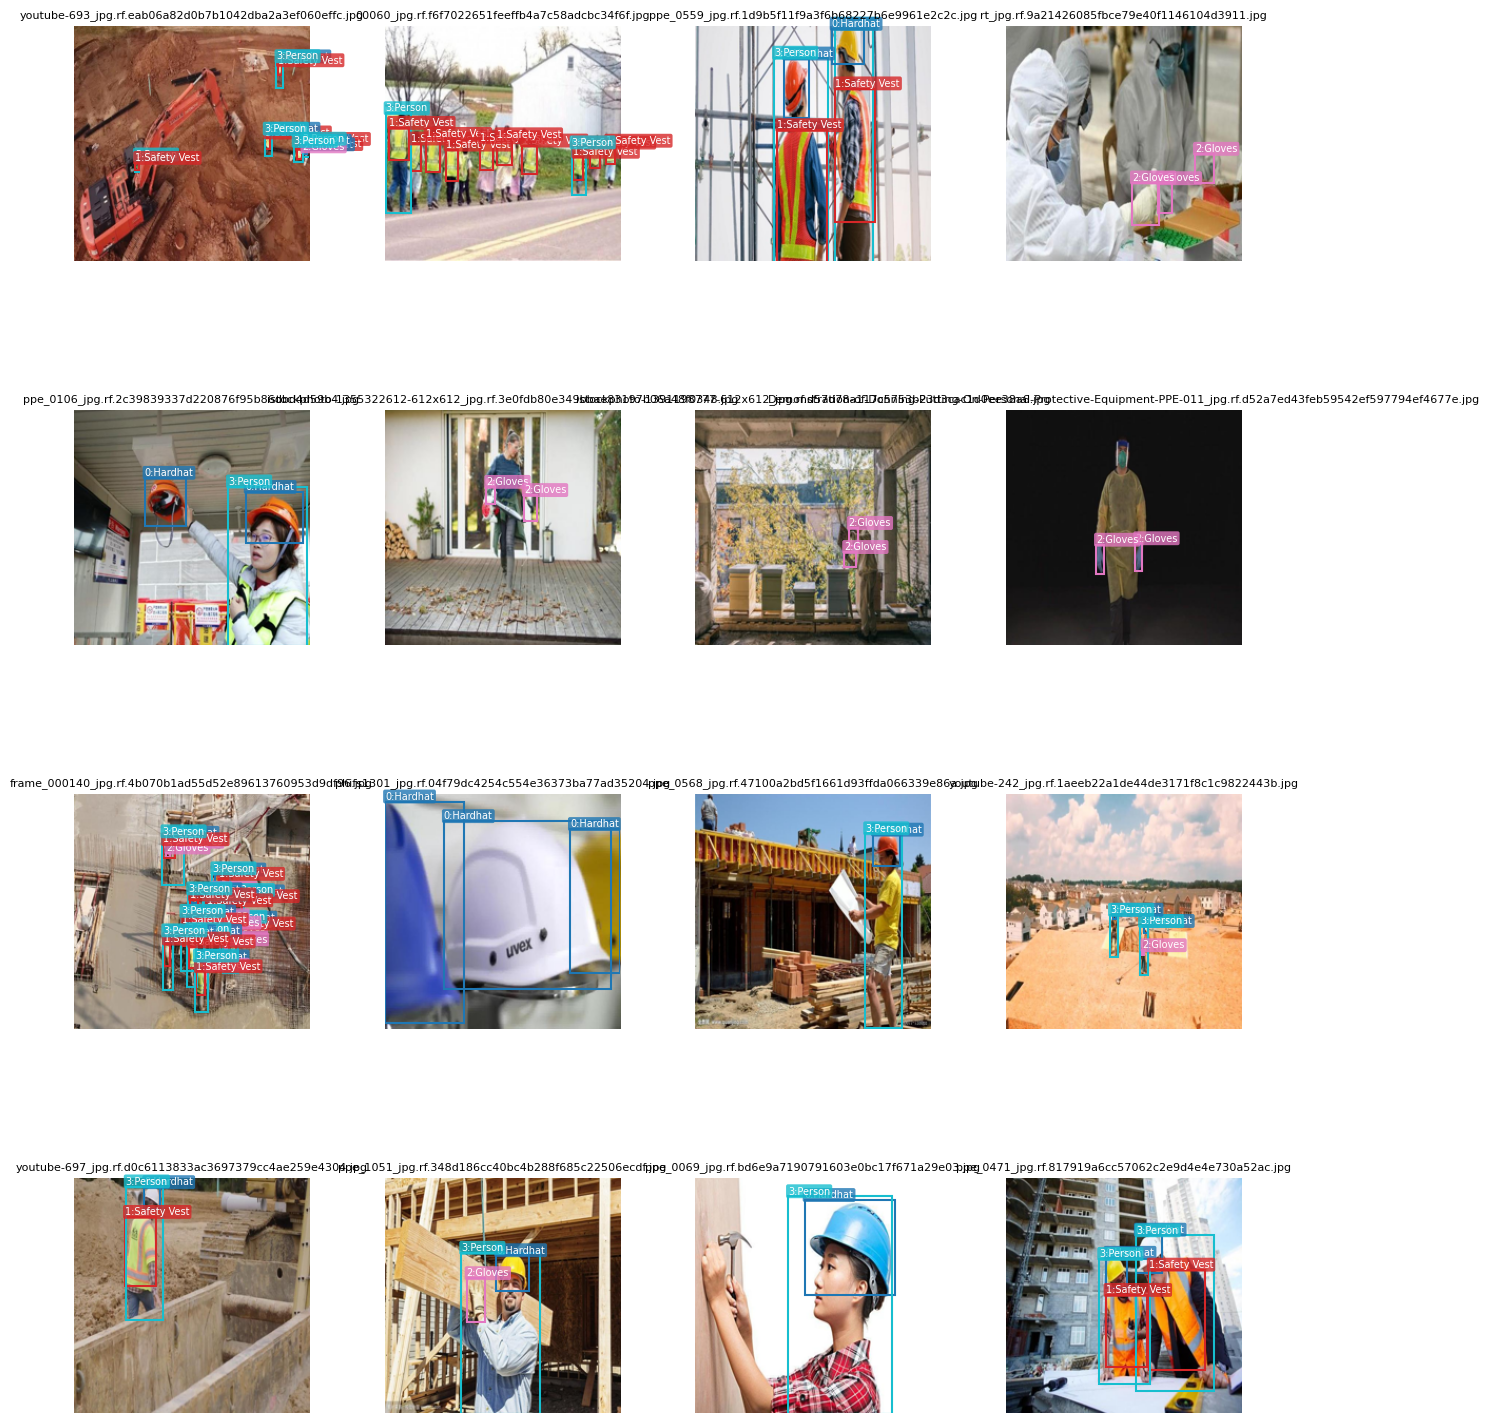

In [22]:
folder_path = '../data/dataset_v4/images'
plot_random_images_from_folder(folder_path, image_size=(224, 224), id=-1)

## Image properties

In [5]:
def get_image_properties(image_path):
    img = cv2.imread(image_path)
    
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [6]:
example_image_path = "../sample/images/1.jpg"
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1280, 'height': 720, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [7]:
import os, pandas as pd

def parse_label_file(path):
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                yield int(parts[0])

def calculate_flat_statistics(labels_dir, classes):
    counts = {c: 0 for c in classes}
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
    for lf in label_files:
        for cls_id in parse_label_file(os.path.join(labels_dir, lf)):
            if 0 <= cls_id < len(classes):
                counts[classes[cls_id]] += 1
    df = pd.DataFrame({'class': list(counts.keys()), 'count': list(counts.values())})
    total = df['count'].sum()
    df['percentage'] = (df['count'] / total * 100).round(2) if total else 0
    df = df.sort_values('count', ascending=False).reset_index(drop=True)
    return df, len(label_files), total

stats_df, num_label_files, total_objects = calculate_flat_statistics(CFG.LABELS_DIR, CFG.CLASSES)
print(f"Label files: {num_label_files}")
print(f"Total annotated objects: {total_objects}")
stats_df

Label files: 2692
Total annotated objects: 15074


,class,count,percentage
0,Person,4847,32.15
1,Hardhat,4294,28.49
2,Gloves,3344,22.18
3,Safety Vest,2589,17.18


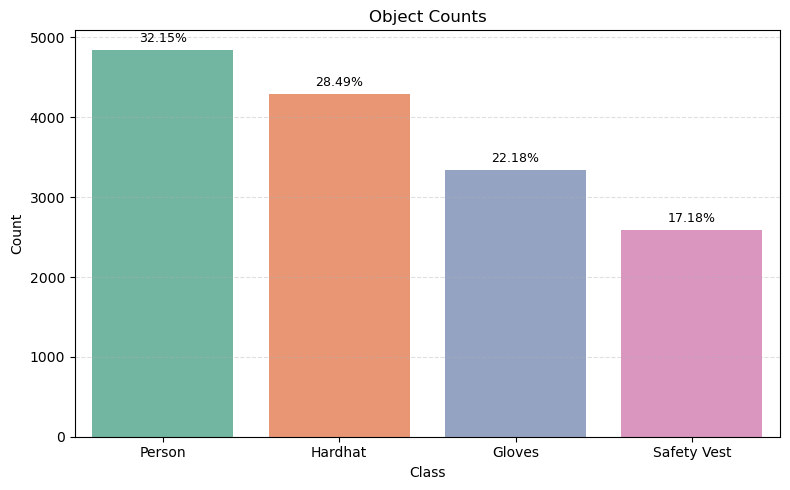

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.barplot(data=stats_df, x='class', y='count', palette='Set2')
for i,row in stats_df.iterrows():
    plt.text(i, row['count'] + stats_df['count'].max()*0.02, f"{row.percentage}%", ha='center', fontsize=9)
plt.title('Object Counts')
plt.ylabel('Count')
plt.xlabel('Class')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Image sizes

Images processed: 2692


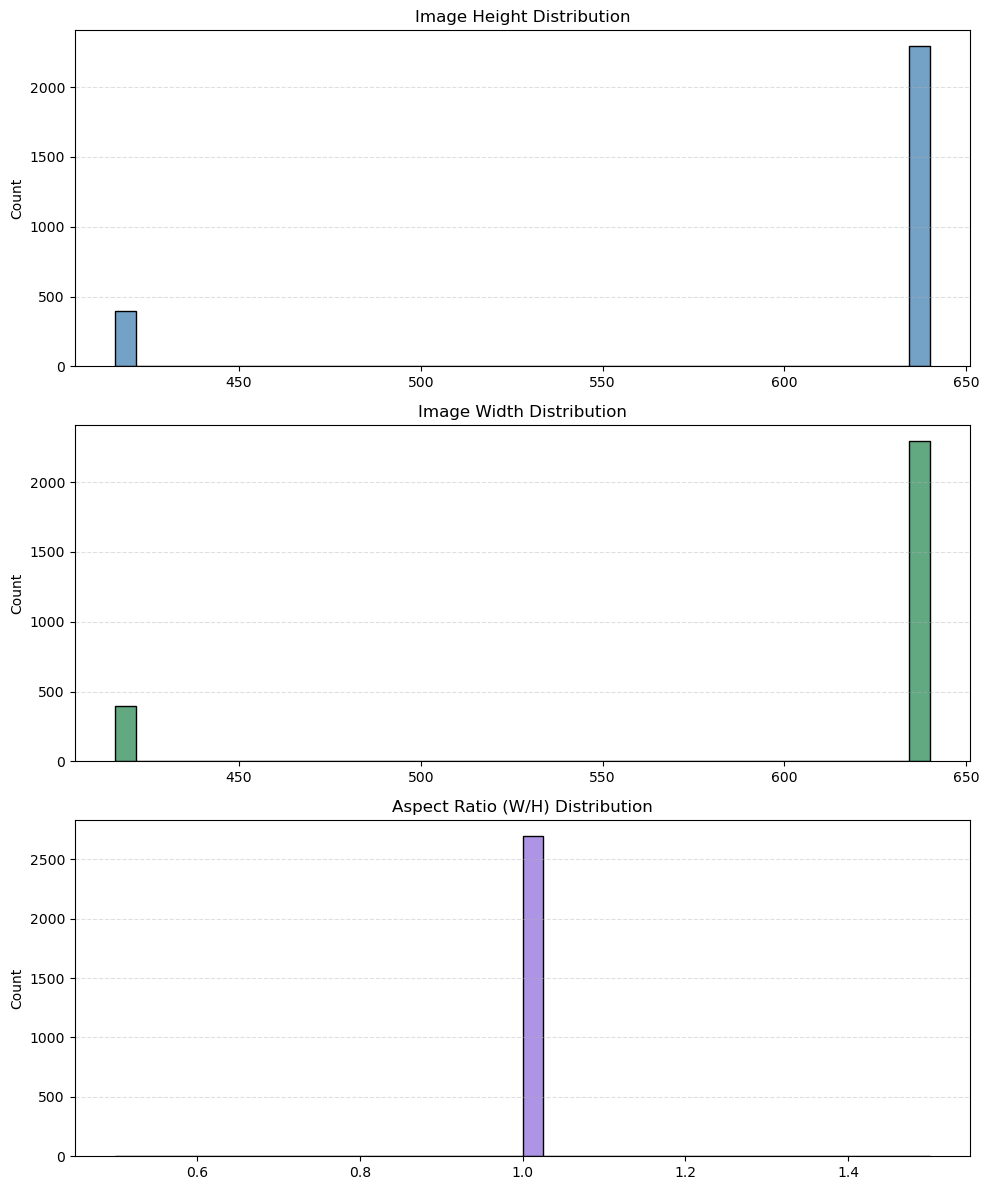

Most common height: 640 (2293 images)
Most common width : 640 (2293 images)
Most common ratio : 1.0 (2692 images)


In [9]:
from PIL import Image
from collections import Counter

image_dir = CFG.IMAGES_DIR
image_heights, image_widths, image_ratios = [], [], []

for f in os.listdir(image_dir):
    if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.webp')):
        path = os.path.join(image_dir, f)
        try:
            with Image.open(path) as img:
                w,h = img.size
                image_widths.append(w)
                image_heights.append(h)
                image_ratios.append(round(w / h, 4))
        except Exception:
            pass

print(f"Images processed: {len(image_widths)}")

fig, axes = plt.subplots(3,1, figsize=(10,12))
sns.histplot(image_heights, bins=40, color='steelblue', ax=axes[0])
axes[0].set_title('Image Height Distribution')
sns.histplot(image_widths, bins=40, color='seagreen', ax=axes[1])
axes[1].set_title('Image Width Distribution')
sns.histplot(image_ratios, bins=40, color='mediumpurple', ax=axes[2])
axes[2].set_title('Aspect Ratio (W/H) Distribution')
for ax in axes: 
    ax.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

if image_heights:
    mc_h = Counter(image_heights).most_common(1)[0]
    mc_w = Counter(image_widths).most_common(1)[0]
    mc_r = Counter(image_ratios).most_common(1)[0]
    print(f"Most common height: {mc_h[0]} ({mc_h[1]} images)")
    print(f"Most common width : {mc_w[0]} ({mc_w[1]} images)")
    print(f"Most common ratio : {mc_r[0]} ({mc_r[1]} images)")

In [10]:
from collections import Counter

most_common_height = Counter(image_heights).most_common(1)[0] 
print(f"Most common height: {most_common_height[0]} (appears {most_common_height[1]} times)")

most_common_width = Counter(image_widths).most_common(1)[0]
print(f"Most common width: {most_common_width[0]} (appears {most_common_width[1]} times)")

most_common_ratio = Counter(image_ratios).most_common(1)[0] 
print(f"Most common ratio: {most_common_ratio[0]:.2f} (appears {most_common_ratio[1]} times)")

Most common height: 640 (appears 2293 times)
Most common width: 640 (appears 2293 times)
Most common ratio: 1.00 (appears 2692 times)


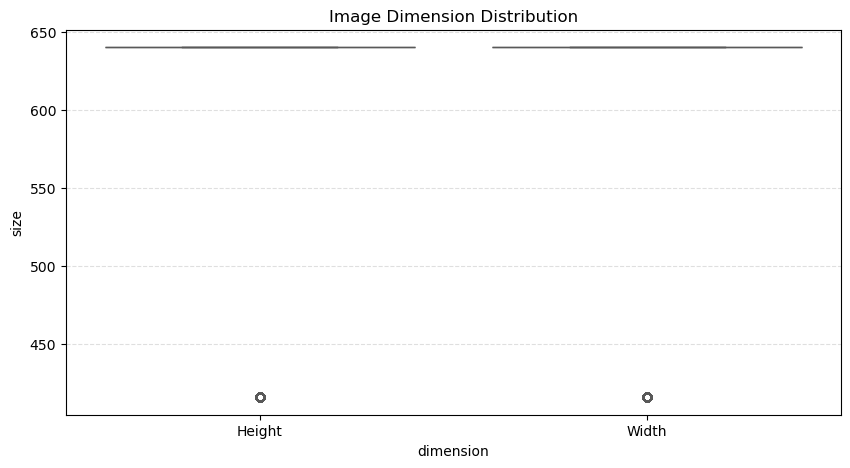

In [11]:
import pandas as pd
dim_df = pd.DataFrame({
    'dimension': ['Height'] * len(image_heights) + ['Width'] * len(image_widths),
    'size': image_heights + image_widths
})
plt.figure(figsize=(10,5))
sns.boxplot(data=dim_df, x='dimension', y='size', palette='Set2')
plt.title('Image Dimension Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()